# Collaborative structural biology using machine learning and Jupyter notebook
##    Fergus Boyles and Fergus Imrie
##    *Department of Statistics, University of Oxford*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

_Load and look:_ Can directly load data from csv using pandas. Don't forget to look at your data!

Should explain what our dataset is, and probably what the features are.

In [2]:
data = pd.read_csv('../data/Data_3DSig.txt', sep=' ')
split = pd.read_csv('../data/Data_Split.txt', sep=' ', header=None)
split.columns = ['Protein', 'Split']
data.head()

,Target,Template,Target_Length,Template_Length,Contact_PPV,Contact_TP,Contact_P,Contact_All,Neff,SeqID,Label
0,d12asa_,d1yfsa2,328,237,4.65,2,43,101,2676,0.177,Fam
1,d12asa_,d1eova2,328,354,22.99,20,87,101,2676,0.223,Fam
2,d12asa_,d1b8aa2,328,336,22.22,20,90,101,2676,0.220,Fam
3,d12asa_,d1l0wa3,328,357,20.00,17,85,101,2676,0.235,Fam
4,d12asa_,d1z7ma1,328,312,1.27,1,79,101,2676,0.211,Fam


In [3]:
data.loc[data.isna().any(axis='columns')]
data.dropna(axis='index', inplace=True)

In [4]:
family_targets = data[(data['Label'] == 'Fam')]['Target'].unique()
superfamily_targets = data[(data['Label'] == 'SFam')]['Target'].unique()
family_targets.shape, superfamily_targets.shape

((10251,), (10698,))

In [7]:
feature_names = data.columns.values[2:-1]

### Scrublord-tier classification: family vs. random
Can we predict, given the features, whether the target and template protein are from the same protein family?

/homes/imrie/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


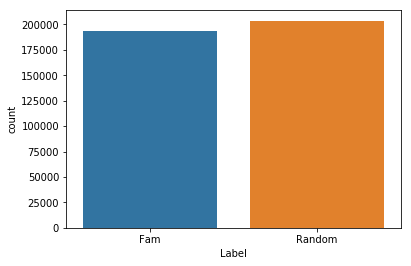

In [5]:
family_data = data[data['Target'].isin(family_targets) & data['Label'].isin(['Fam', 'Random'])]
sns.countplot(data=family_data, x='Label')

Data is balanced so don't need to worry about any imbalance.

Important that we decide train/validation/test sets before we go any further. We adopt a 80/10/10 split. Note below that we sample a subset (5000) of the total number of proteins (10251). Also note that we're splitting *by target* rather than simply splitting the examples. This ensures that all examples for a target are in the same set.

Also, for reproducibility, we set the seed for our random number generator.

In [8]:
np.random.seed(42)
n_samples = 5000
sample = np.random.choice(family_targets, size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

In [9]:
family_data[family_data['Target'].isin(train)].shape, family_data[family_data['Target'].isin(validation)].shape, family_data[family_data['Target'].isin(test)].shape

((154180, 11), (19368, 11), (19444, 11))

Construct placeholder variables for our split.

Binarise the label.

In [10]:
X_train = family_data[family_data['Target'].isin(train)][feature_names].values
X_validation = family_data[family_data['Target'].isin(validation)][feature_names].values
X_test = family_data[family_data['Target'].isin(test)][feature_names].values

y_train = family_data[family_data['Target'].isin(train)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_validation = family_data[family_data['Target'].isin(validation)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_test = family_data[family_data['Target'].isin(test)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()

Train a random forest classifier. Note how we're explicitly setting the random seed. Parameters somewhat arbitrary and in general not too sensitive for RF.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

Prediction time!

In [12]:
y_pred = rf.predict(X_test)
y_score_oob = [p[1] for p in rf.oob_decision_function_]
y_pred_oob = [round(p) for p in y_score_oob]
y_score_test = [p[1] for p in rf.predict_proba(X_test)]
y_pred_validation = rf.predict(X_validation)
y_score_validation = [p[1] for p in rf.predict_proba(X_validation)]

How to asssess your performance on a classification task? Many possible answers and certainly not a single correct one. Here we consider ROC and precision-recall curves. Given not much class imbalance, curves tell similar stories, but not always the case.

Note OOB performance. Do we expect this? Why might this be the case?

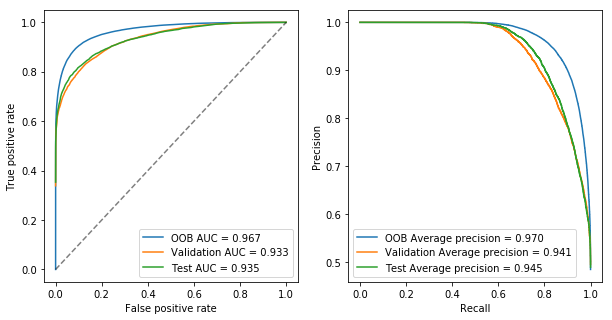

In [13]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fpr, tpr, _ = roc_curve(y_train, y_score_oob)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'OOB AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_train, y_score_oob)
pr_score = average_precision_score(y_train, y_score_oob)
ax2.step(recall, precision, label=f'OOB Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_validation, y_score_validation)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Validation AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_validation, y_score_validation)
pr_score = average_precision_score(y_validation, y_score_validation)
ax2.step(recall, precision, label=f'Validation Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Test AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_test, y_score_test)
pr_score = average_precision_score(y_test, y_score_test)
ax2.step(recall, precision,  label=f'Test Average precision = {pr_score:.3f}')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend()

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

__Confusion matrix:__ Different way to visualise performance of our classifier. We see there aren't many false positives (bottom right) but quite a few false negatives (top right).

0.86047109648220532

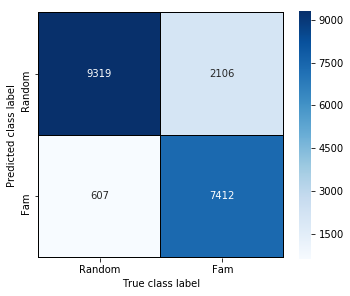

In [14]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).T
cm.rename({0: 'Random', 1: 'Fam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'Fam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_test, y_test)

# Apprentice-tier classification: superfamily vs. random

Now we move onto the problem of classifying whether a target and template are in the same superfamily.

/homes/imrie/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


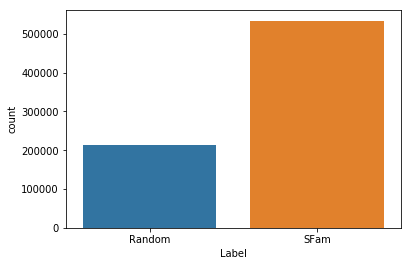

In [15]:
superfamily_data = data[data['Target'].isin(superfamily_targets) & data['Label'].isin(['SFam', 'Random'])]
sns.countplot(data=superfamily_data, x='Label')

You can see we have rougly the same number of negative examples, but many more positive examples. 

Class imbalance is a huge issue when training clasifiers. We choose to undersample superfamily data so that we have an even number of random and superfamily datapoints. 

In [16]:
# Undersample 'SFam' data

sfam_data_counts = superfamily_data['Label'].value_counts()

In [17]:
sfam_idx = superfamily_data[superfamily_data['Label'] == 'SFam'].index.values
np.random.seed(42)
#n_to_drop = 534040 - 211592 # Huh? FI
n_to_drop = max(sfam_data_counts.values) - min(sfam_data_counts.values) # Prefer this implementation
to_drop = np.random.choice(sfam_idx, size=n_to_drop, replace=False)
superfamily_data.drop(to_drop, axis='index', inplace=True)

/homes/imrie/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


/homes/imrie/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


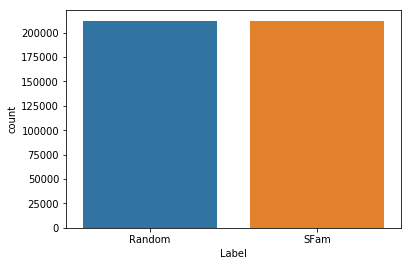

In [18]:
sns.countplot(data=superfamily_data, x='Label')

Same as before: (i) split data, (ii) train classifier, (iii) test predictions.

In [19]:
np.random.seed(42)
n_samples = 5000
sample = np.random.choice(superfamily_targets, size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

In [20]:
superfamily_data[superfamily_data['Target'].isin(train)].shape, superfamily_data[superfamily_data['Target'].isin(validation)].shape, superfamily_data[superfamily_data['Target'].isin(test)].shape

((158215, 11), (20456, 11), (19313, 11))

In [21]:
X_train = superfamily_data[superfamily_data['Target'].isin(train)][feature_names].values
X_validation = superfamily_data[superfamily_data['Target'].isin(validation)][feature_names].values
X_test = superfamily_data[superfamily_data['Target'].isin(test)][feature_names].values

y_train = superfamily_data[superfamily_data['Target'].isin(train)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()
y_validation = superfamily_data[superfamily_data['Target'].isin(validation)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()
y_test = superfamily_data[superfamily_data['Target'].isin(test)]['Label'].replace({'Random': 0, 'SFam': 1}).values.ravel()

In [22]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_score_oob = [p[1] for p in rf.oob_decision_function_]
y_pred_oob = [round(p) for p in y_score_oob]
y_score_test = [p[1] for p in rf.predict_proba(X_test)]
y_pred_validation = rf.predict(X_validation)
y_score_validation = [p[1] for p in rf.predict_proba(X_validation)]

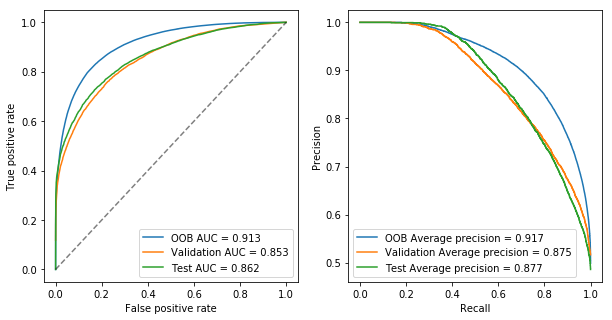

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fpr, tpr, _ = roc_curve(y_train, y_score_oob)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'OOB AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_train, y_score_oob)
pr_score = average_precision_score(y_train, y_score_oob)
ax2.step(recall, precision, label=f'OOB Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_validation, y_score_validation)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Validation AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_validation, y_score_validation)
pr_score = average_precision_score(y_validation, y_score_validation)
ax2.step(recall, precision, label=f'Validation Average precision = {pr_score:.3f}')

fpr, tpr, _ = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, label=f'Test AUC = {roc_auc:.3f}')

precision, recall, _ = precision_recall_curve(y_test, y_score_test)
pr_score = average_precision_score(y_test, y_score_test)
ax2.step(recall, precision,  label=f'Test Average precision = {pr_score:.3f}')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.legend()

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend()

Classifier now isn't as good but still exhibits fairly appreciable predictive power.

We have the same issue as before begarding false negatives, with limited false positives.

As expected given how we split this and trained, limited difference between the validation and test set.

0.7613964647701121

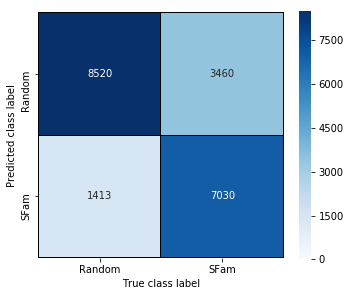

In [22]:
cm = pd.DataFrame(confusion_matrix(y_validation, y_pred_validation)).T
cm.rename({0: 'Random', 1: 'SFam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'SFam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', vmin=0, cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_validation, y_validation)

0.7798008092125739

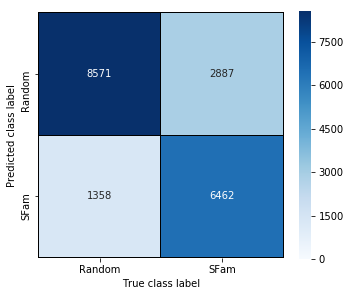

In [23]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred)).T
cm.rename({0: 'Random', 1: 'SFam'}, axis='index', inplace=True)
cm.rename({0: 'Random', 1: 'SFam'}, axis='columns', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True, linewidths=0.1, linecolor='k', vmin=0, cbar_kws={'shrink': 0.75}, ax=ax)
ax.set_ylabel('Predicted class label')
ax.set_xlabel('True class label')
fig.tight_layout()
rf.score(X_test, y_test)

# Grouped k-fold CV using sklearn

In [24]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

family_data = data[data['Target'].isin(family_targets) & data['Label'].isin(['Fam', 'Random'])]

feature_names = ['Target_Length', 'Template_Length', 'Contact_PPV', 'Contact_TP', 'Contact_P', 'Contact_All', 'Neff', 'SeqID']
np.random.seed(42)
n_samples = 1000
sample = np.random.choice(family_targets, size=n_samples, replace=False)
n_train = int(0.8*n_samples)
n_valid = int(0.1*n_samples)
train = sample[:n_train]
validation = sample[n_train:n_train+n_valid]
test = sample[n_train+n_valid:]

groups = family_data[family_data['Target'].isin(train)]['Target'].values

X_train = family_data[family_data['Target'].isin(train)][feature_names].values
X_validation = family_data[family_data['Target'].isin(validation)][feature_names].values
X_test = family_data[family_data['Target'].isin(test)][feature_names].values

y_train = family_data[family_data['Target'].isin(train)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_validation = family_data[family_data['Target'].isin(validation)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()
y_test = family_data[family_data['Target'].isin(test)]['Label'].replace({'Random': 0, 'Fam': 1}).values.ravel()

In [25]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1, random_state=42)
clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42)

In [26]:
scores = cross_validate(clf, X_train, y_train, scoring='roc_auc', cv=GroupKFold(n_splits=3).split(X_train, y_train, groups), return_train_score=False, n_jobs=-1)